In [2]:
import spikeinterface.full as si
#import spikeinterface.core as si
import spikeinterface.extractors as se
import spikeinterface.preprocessing as spiketoolkit
import spikeinterface.widgets as sw
import numpy as np
from convert_positions_in_tones import *
from utils_extraction import *
sr=30e3

In [28]:
root = '/mnt/working2/felicie/Python_theremin/Analyse/Analyse/Experiment/BURRATA/BURRATA_20240420_SESSION_01/'
path = root+'headstage_1/'

In [69]:
tr = '/mnt/working2/felicie/Python_theremin/Analyse/Analyse/Experiment/BURRATA/BURRATA_20240420_SESSION_01/headstage_1/dig_in.npy'
triggers = np.load(tr)
triggers = triggers.astype(np.int8)
print(triggers)

[[0 0 0 ... 1 1 1]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [70]:

spk = ut.Spikes(path)
triggers = np.load(os.path.join(path, "dig_in.npy"))[0]
triggers = triggers.astype(np.int8)
triggers = ut.extract_trigger_time(triggers)

clusters = np.arange(32)
t_pre = 0.2
t_post = 0.75
bin_size = 0.01
bins = np.arange(-t_pre, t_post + bin_size, bin_size)
centers = np.zeros(len(bins) - 1)
for i in range(len(bins) - 1):
    centers[i] = (bins[i + 1] + bins[i]) / 2
    # print(centers)
for cluster in clusters:
    tracking = list()
    psth, _ = ut.psth(spikes=spk.get_spike_times(cluster), triggers=triggers,
                                   bins=bins, t_0=t_pre, t_1=t_post, bin_size=bin_size)
    tracking.append(psth)
    


In [71]:
spk = ut.Spikes(path)
triggers = np.load(os.path.join(path, "dig_in.npy"))[0]
triggers = triggers.astype(np.int8)
triggers = ut.extract_trigger_time(triggers)
print(triggers)

[  170253   170442   170632 ... 25162080 25162263 25162458]


In [72]:
np.save(path+'psth.npy', tracking)

In [10]:
positions_files = get_positions_playback(root, 'pbOnly')

In [6]:
xy_mock = load_bin_file_with_numpy(positions_files[0])
x_mock = xy_mock[::2]


In [12]:
t_manip = len(x_mock)/160
t_neural = len(neural_data[0])/sr
print(t_manip, t_manip/60)
print('t_neural', t_neural)

832.775 13.879583333333333
t_neural 838.7498666666667


In [33]:
delta = t_neural-t_manip # en secondes

In [48]:
# load le rhd
load_rhd(root+'ephys.rhd', root, digital=True, analog=True, accelerometer=True, filtered=False, export_to_dat=False)



Reading Intan Technologies RHD2000 Data File, Version 3.3

n signal groups 7
Found 64 amplifier channels.
Found 6 auxiliary input channels.
Found 0 supply voltage channels.
Found 8 board ADC channels.
Found 16 board digital input channels.
Found 0 board digital output channels.
Found 0 temperature sensors channels.

File contains 838.750 seconds of data. Amplifiers were sampled at 30.00 kS/s.

Allocating memory for data...
Reading data from file...
10% done...
20% done...
30% done...
40% done...
50% done...
60% done...
70% done...
80% done...
90% done...
Parsing data...
No missing timestamps in data.
Done!  Elapsed time: 31.4 seconds


'/mnt/working2/felicie/Python_theremin/Analyse/Analyse/Experiment/BURRATA/BURRATA_20240420_SESSION_01/neural_data.npy'

In [18]:
import numpy as np
import spikeinterface
import zarr as zr
import os
from  pathlib import Path
import tqdm
import spikeinterface.full as si
from spikeinterface.sortingcomponents.peak_detection import detect_peaks
from probeinterface import Probe, ProbeGroup


In [49]:
sig = neural_data[32:]
print(len(sig))

32


In [19]:
def get_fma_probe():
    """ Implements the FMA probe using Probeinterface.
        Particular care has to be taken on how the headstage is connected on the probe.
    """
    ### The following distances are in mm:
    inter_hole_spacing = 0.4  # along one row
    inter_row_spacing = np.sqrt(0.4**2-0.2**2)  # between row
    dist_from_orig = 0.4
    pos_row_x = np.array([dist_from_orig, dist_from_orig + inter_row_spacing / 2])
    pos_row_y = np.array([dist_from_orig + inter_hole_spacing * i for i in range(16)])
    POSX_orig = np.tile(pos_row_x, (16, 1))
    POSY_orig = np.tile(pos_row_y[:, np.newaxis], (1, 2))

    positions = np.stack([POSX_orig, POSY_orig], axis=-1)
    positions = positions.reshape((-1, 2))
    positions = positions * 1000  # Convert to micrometers

    # We need to remove the ground from these positions:
    mask = np.zeros((16, 2), dtype=bool)
    mask[[0, 15], [0, 1]] = True
    positions = positions[np.logical_not(mask.reshape(-1))]

    probe = Probe(ndim=2, si_units='um')
    probe.set_contacts(positions=positions,
                       shapes='circle', shape_params={'radius': 100})
    polygon = [(0, 0), (0, 16000), (800, 16000), (800, 0)]
    probe.set_planar_contour(polygon)

    ## This mapping is ordered from 32 to 1, so we use[::-1] to invert it and make it 1 to 32
    mapping = np.arange(32).reshape(16, 2)[::-1].reshape(-1)
    mapping = mapping[np.logical_not(mask.reshape(-1))]

    probe.set_device_channel_indices(mapping)

    return probe





n_cpus = os.cpu_count()

In [50]:
probe = get_fma_probe()
sr=30e3
full_raw_rec = se.NumpyRecording(traces_list=np.transpose(sig), sampling_frequency=sr)
#raw_rec = full_raw_rec.set_probe(probe)
#raw_rec = raw_rec.remove_channels(["CH2"])
recording_cmr = si.common_reference(full_raw_rec, reference='global', operator='median')
recording_f = si.bandpass_filter(full_raw_rec, freq_min=300, freq_max=9000)

#rec_clean = si.remove_artifacts(recording=recording_f, list_triggers=an_times, mode='zeros')

In [60]:
sr=30e3
n_cpus = os.cpu_count()
n_jobs = n_cpus - 4
job_kwargs = dict(chunk_duration='5s', n_jobs=n_jobs, progress_bar=True)

peaks = detect_peaks(
        recording_f,
        method='by_channel',
        gather_mode="memory",
        peak_sign='neg',
        detect_threshold=2,
        exclude_sweep_ms=0.1,
        noise_levels=None,
        random_chunk_kwargs={},

        **job_kwargs,
)

detect peaks using by_channel:   0%|          | 0/168 [00:00<?, ?it/s]

In [61]:
peaks_array = np.array(peaks)
spk_times = peaks_array['sample_index'].tolist()
spk_clusters = peaks_array['channel_index'].tolist()
np.save(root+'/test/spk_times.npy',spk_times )
np.save(root+'/test/spk_clusters.npy',spk_clusters)

REPRENDRE ICI pour enregistrer les spk_times et spk_clusters proprement et les tester ensuite !!!!!!!!!!!!!!!!!!!!!!!

In [ ]:
#quick_extract(root+'/high_pass_neural_data.npy', mode="absolute", threshold=-70)

In [41]:
path_test=root+'/test'
spk_times = np.load(path+'spike_times.npy', allow_pickle=True)
spk_clusters = np.load(path+'spike_clusters.npy', allow_pickle=True)

In [62]:
clusters = {}
for value, cluster in zip(spk_times, spk_clusters):
    if cluster not in clusters:
        clusters[cluster] = []
    clusters[cluster].append(value)
for cluster, values in clusters.items():
    print(f"Cluster {cluster}: {len(values)}")

Cluster 2: 379425
Cluster 4: 401743
Cluster 5: 421267
Cluster 1: 388319
Cluster 3: 389457
Cluster 6: 418559
Cluster 7: 409221
Cluster 11: 438617
Cluster 14: 399412
Cluster 15: 435600
Cluster 16: 449535
Cluster 23: 413311
Cluster 24: 444537
Cluster 25: 486675
Cluster 27: 438553
Cluster 0: 433843
Cluster 8: 469435
Cluster 9: 411864
Cluster 10: 423727
Cluster 12: 385554
Cluster 13: 415185
Cluster 17: 417513
Cluster 18: 405214
Cluster 19: 540829
Cluster 20: 447824
Cluster 21: 403995
Cluster 22: 428931
Cluster 26: 461503
Cluster 28: 440680
Cluster 29: 405288
Cluster 30: 436484
Cluster 31: 458479


In [ ]:
#2eme technique
quick_extract(root+'/high_pass_neural_data.npy', mode="absolute", threshold=-70)

In [54]:
an_triggers = np.load(os.path.join(path, "analog_in.npy"))
an_times = ut.extract_analog_triggers_compat(an_triggers[0])
frequencies, tones_total, triggers_spe, tag = get_data(path, trigs=an_times)
new_an_times = an_times+delta*sr
                                                       

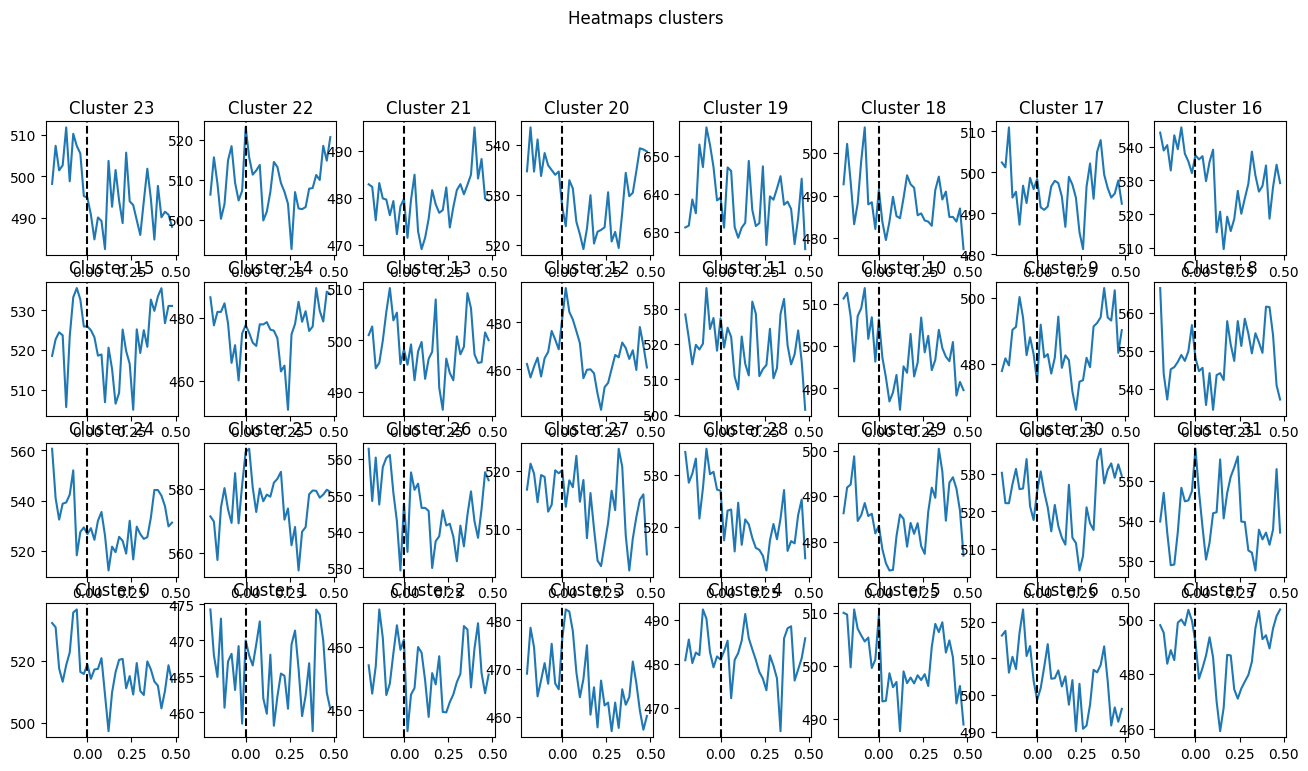

In [63]:
t_pre = 0.2#0.2
t_post = 0.50#0.300
bin_width = 0.02
# Créer les bins de temps"
psth_bins = np.arange(-t_pre, t_post, bin_width)
window = [-t_pre, t_post]

import numpy as np
import matplotlib.pyplot as plt

def compute_psth(spike_times, stimulus_times, bin_size, window):
    # Combine all spikes relative to stimulus times
    stimulus_times = stimulus_times/sr
    spike_times = spike_times/sr
    all_spikes = []
    for stim_time in stimulus_times:
        relative_spikes = spike_times - stim_time
        all_spikes.extend(relative_spikes[(relative_spikes >= window[0]) & (relative_spikes <= window[1])])
    
    # Create histogram
    bins = np.arange(window[0], window[1] + bin_size, bin_size)
    hist, bin_edges = np.histogram(all_spikes, bins=bins)
    
    # Normalize to get the firing rate
    psth = hist / (len(stimulus_times) * bin_size)
    #psth=hist
    return psth, bin_edges

gc = np.arange(0,32)
num_plots, num_rows, num_columns = get_better_plot_geometry(gc)


fig, axes = plt.subplots(4, 8, figsize=(16, 8))
fig.suptitle('Heatmaps clusters', y=1.02)
plt.subplots_adjust() 

stim_times = an_times
    #
for cluster in range(num_plots):
    if cluster < num_plots:
        row, col = get_plot_coords(cluster)
        spike_times = np.array(clusters[cluster])
        psth,edges = compute_psth(spike_times, stim_times, bin_width, window)
        axes[row, col].plot(psth_bins, psth)
        axes[row, col].axvline(0, c = 'black', linestyle='--')
        axes[row, col].set_title(f'Cluster {cluster}')


In [332]:
new_an_times

array([  320997.97486667,   375327.97486667,   527759.97486667, ...,
       24939451.97486667, 25116273.97486667, 25138383.97486667])

In [234]:

import spikeinterface.extractors as se
import spikeinterface.widgets as sw

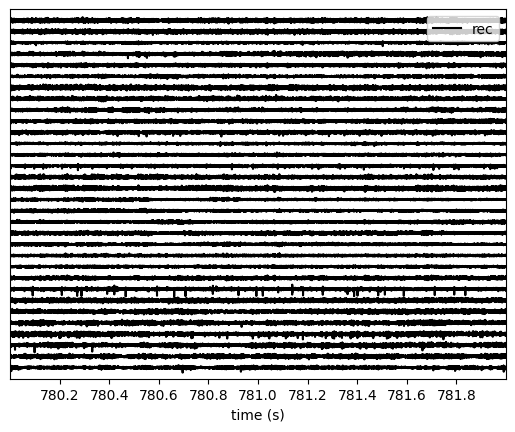

In [263]:
w_ts = sw.plot_traces(recording_f,time_range=(13*60, 13*60+2))

In [259]:
an_times/sr

array([ 10.69973333,  12.51073333,  17.5918    , ..., 831.31486667,
       837.20893333, 837.94593333])